In [1]:
import glob
import json
from collections import defaultdict

import numpy as np
from matplotlib import pyplot as plt

## All benchmarks, all hyperparameters are learned

/tmp/ipykernel_7109/3556577088.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


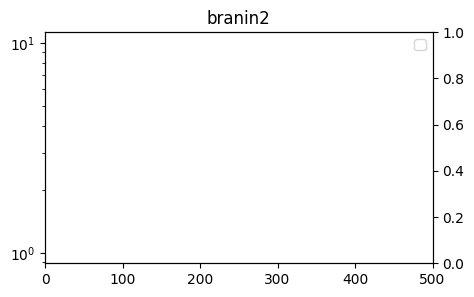

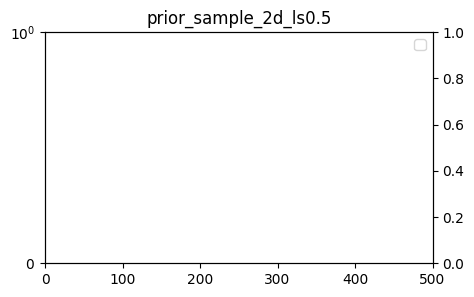

[184, 114, 368]


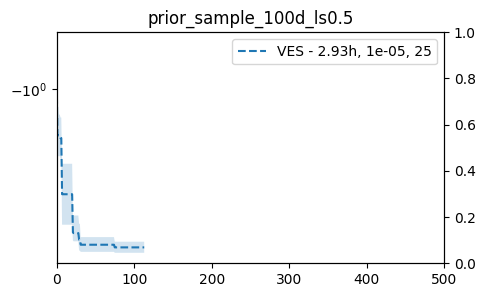

[220, 103, 105]


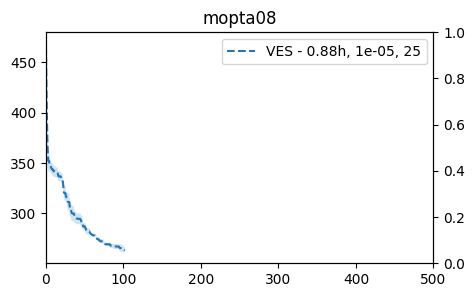

In [2]:
import os
from zlib import adler32

benchmarks = ['branin2', 'prior_sample_2d_ls0.5', 'prior_sample_100d_ls0.5', 'mopta08']
runtime_benchmarks = benchmarks

run_dirs = glob.glob('../results/runtime2/*')

NUM_PATHS = 256

for benchmark in benchmarks:
    
    def general_dir_match(
            args: dict,
    ):
        if not 'prior_sample' in benchmark:
            return True
        else:
            ls = float(benchmark.split('_')[-1][2:])
            set_ls = args['set_lengthscale'] 
            return set_ls is None# and float(ls) == float(set_ls)
        
    ves_res = defaultdict(list)
        
    if benchmark in benchmarks:
        relevant_dirs = [d for d in run_dirs if json.load(open(f'{d}/args.json'))['benchmark'] == benchmark]

        # VES experiments are mssing, put it here temporarily
        
        relevant_dirs = [d for d in relevant_dirs if general_dir_match(json.load(open(f'{d}/args.json'))) and 'train_x_ves.npy' in os.listdir(d)]
        
        for rdir in relevant_dirs:
            ves_y = np.maximum.accumulate(np.load(f'{rdir}/train_y_ves.npy'))
            runtime_in_s = float(open(f'{rdir}/time_taken.txt').read()) if os.path.exists(f'{rdir}/time_taken.txt') else np.nan
            runtime_in_h = runtime_in_s / 3600
            args = json.load(open(f'{rdir}/args.json'))
            stop_tolerance_coeff = args['stop_tolerance_coeff']
            num_iters = args['num_iter']
            args_hash = adler32(json.dumps(args, sort_keys=True).encode())
            ves_res[args_hash].append((ves_y, runtime_in_h, stop_tolerance_coeff, num_iters))
        
    fig, ax = plt.subplots(figsize=(5, 3))
    ax2 = ax.twinx()

    for args_hash, res_list in ves_res.items():
        ves_y = [res[0] for res in res_list]
        runtime_in_h = [res[1] for res in res_list]
        stop_tolerance_coeff = [res[2] for res in res_list]
        num_iters = [res[3] for res in res_list]
        
        mean_runtime = np.nanmean(runtime_in_h)
        min_len = min([len(y) for y in ves_y])
        print([len(y) for y in ves_y])
        ves_y = [y[:min_len] for y in ves_y]
        ves_y = -np.stack(ves_y).squeeze(-1)
        ves_y_mean = ves_y.mean(axis=0)
        ves_y_std = ves_y.std(axis=0)/ np.sqrt(len(ves_y))
        ax.plot(ves_y_mean, label=f'VES - {mean_runtime:.2f}h, {stop_tolerance_coeff[0]}, {num_iters[0]}', linestyle='--')
        ax.fill_between(np.arange(len(ves_y_mean)), ves_y_mean-ves_y_std, ves_y_mean+ves_y_std, alpha=0.2)
        
    ax.legend()
    ax.set_title(f'{benchmark}')
    if benchmark == 'branin2':
        ax.set_yscale('log')
    if benchmark.startswith('prior_sample'):
        # find best value
        ax.set_yscale('symlog')
    ax.set_xlim(0, 500)
    # fig.savefig(f'figs/gp_prior/learn/{benchmark}.pdf', format='pdf', bbox_inches='tight', dpi=100)
    plt.show()
    
    